In [1]:
# Cell loads the data

from dataset_loader import data_loader, get_descriptors, one_filter, data_scaler
import os, sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
from sklearn import preprocessing
# file name and data path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_path = os.getcwd()
file_name = 'data/CrystGrowthDesign_SI.csv'

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = ['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
one_filter_columns = ['H2@100 bar/243K (wt%)'] 
another_filter_columns = ['H2@100 bar/130K (wt%)'] 

# load data
data = data_loader(base_path, file_name)
data = data.reset_index(drop=True)
# extract descriptors and gas adsorptions
one_property = one_filter(data, one_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# prepare training inputs and outputs
X = np.array(descriptors.values, dtype=np.float32)
y = np.array(one_property.values, dtype=np.float32).reshape(len(X), )
X = data_scaler(X)
y = data_scaler(y.reshape(-1, 1)).reshape(len(X),)
# removes catagorical varaiables
test=data.drop(["MOF ID","topology","First nodular character","Second nodular character"],axis=1)
#g_comp=5
# all vs just used !!!! uncomment below for just feature used anaylsis
g_comp=6
test=test[['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']]
g=preprocessing.StandardScaler().fit_transform(test)
g=pd.DataFrame(g)
g.columns=test.columns
test=g

In [2]:
# made my own helper functions 
# just plots pca 1,2 with how ever many gausian clusters on test data
from Statistics_helper import make_pca_agg_fit
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
var=.9
_,_,color=make_pca_agg_fit(1,test,var,g_comp,array_out=True)

# Notice that the clusters are verticle..

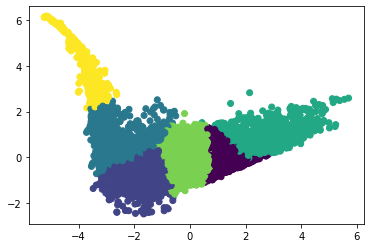

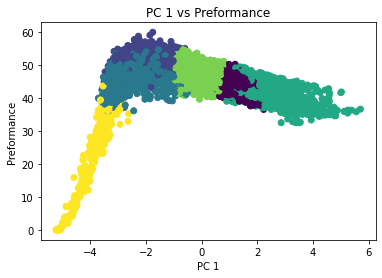

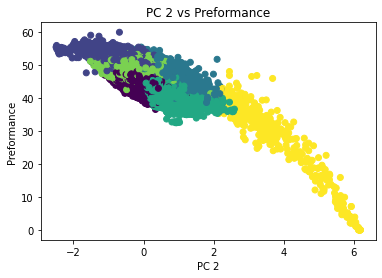

In [3]:
from sklearn.cluster import KMeans
_,_,color=make_pca_agg_fit(1,test,var,g_comp,func_give=KMeans,array_out=True)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
Out=PCA(n_components=2)
g=Out.fit(test)
a=g.transform(test)
pc1=a.T[:][0]
pc2=a.T[:][1]
plt.scatter(pc1,pc2,c=color)
plt.show()
plt.title("PC 1 vs Preformance")
plt.xlabel(f"PC 1")
plt.ylabel(f"Preformance")
plt.scatter(pc1,data['H2@100 bar/77K (g/L)'],c=color)
plt.show()
plt.title("PC 2 vs Preformance")
plt.xlabel(f"PC 2")
plt.ylabel(f"Preformance")
plt.scatter(pc2,data['H2@100 bar/77K (g/L)'],c=color)
plt.show()

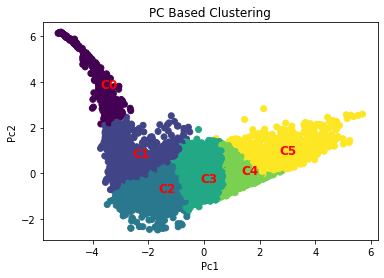

In [4]:
Out=PCA(n_components=2)
g=Out.fit(test)
data2=data.copy()
g_comp=6
holder=['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
for i in holder:
    temp=data2[holder]
    g=preprocessing.StandardScaler().fit_transform(temp)
    g=pd.DataFrame(g)
pc1,pc2,color=make_pca_agg_fit(1,g,var,g_comp,func_give=KMeans,array_out=True)
dic={
    "Pc1" : pc1,
    "Pc2" : pc2,
    "Cluster" : color,
}
holder=pd.DataFrame(dic)
data2=pd.concat([data2,holder],axis=1)
def manual_swap(x):
    #swaps clusters to order from left to right on pca
    x=int(x)
    y=0
    if x == 5:
         y=0
    elif x == 2:
        y= 1
    elif x== 1:
        y=2
    elif x == 4:
        y=3
    elif x == 0:
        y=4
    else:
        y=5
    return y
data2["Cluster"]=data2["Cluster"].apply(manual_swap)
plt.scatter(data2["Pc1"],data2["Pc2"],c=data2["Cluster"])
plt.ylabel("Pc2")
plt.xlabel("Pc1")
plt.title("PC Based Clustering")
abridge=data2[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Second nodular character', 'Second nodular ID',
       'Connecting building block ID', 'Pc1', 'Pc2', 'Cluster']]
new=data2[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest','topology',
       'First nodular symmetry code', 'First nodular character',
       'First nodular ID', 'Second nodular symmetry code',
       'Second nodular character', 'Second nodular ID',
       'Connecting building block ID', 'Pc1', 'Pc2', 'Cluster']].groupby("Cluster").mean()
#plt.scatter(new["Pc1"],new["Pc2"],c="r")
annotations=["C0","C1","C2","C3","C4","C5"]
for i, label in enumerate(annotations):
    plt.annotate(label, (new["Pc1"][i],new["Pc2"][i]),weight='bold',c="r",size=12)

In [5]:
dic={}
for i in abridge["topology"].unique():
    dic[i]=[]
for i in range(6):
    Cluster1=abridge[abridge["Cluster"]==i]
    for j in abridge["topology"].unique():
        if sum(Cluster1["topology"]==j) > 0:
            dic[j].append(sum(Cluster1["topology"]==j))
        else:
            dic[j].append(0)


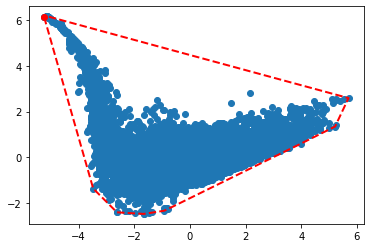

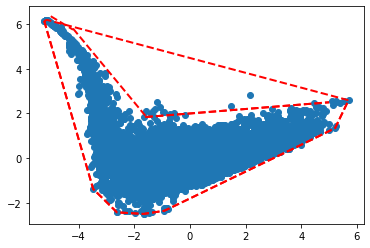

In [6]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
alpha_tuples=[[a,b] for a,b in zip(data2["Pc1"].to_numpy(),data2["Pc2"].to_numpy())]
alpha_tuples=np.array(alpha_tuples)
hull=ConvexHull(alpha_tuples)
plt.plot(alpha_tuples[:,0], alpha_tuples[:,1], 'o')
plt.plot(alpha_tuples[hull.vertices,0], alpha_tuples[hull.vertices,1], 'r--', lw=2)
plt.plot(alpha_tuples[hull.vertices[0],0], alpha_tuples[hull.vertices[0],1], 'ro')
plt.show()
plt.plot(alpha_tuples[:,0], alpha_tuples[:,1], 'o')
plt.plot(alpha_tuples[hull.vertices,0], alpha_tuples[hull.vertices,1], 'r--', lw=2)
x=np.linspace(-4.2,-1.6,1001)
y= lambda x: -.5 - 1.5*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-5,-4.2,1001)
y= lambda x: 2.6- .75*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-1.6,5,1001)
y= lambda x: 2 + .1*x
plt.plot(x,y(x),'r--', lw=2)
x=np.linspace(-1.6,5,1001)
y= lambda x: 2 + .1*x
plt.plot(x,y(x),'r--', lw=2)
plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)

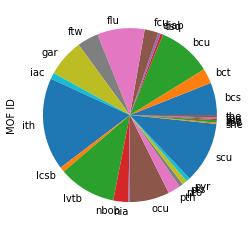

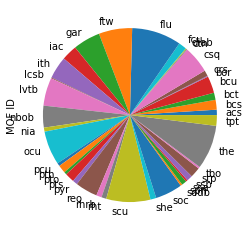

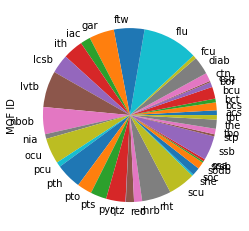

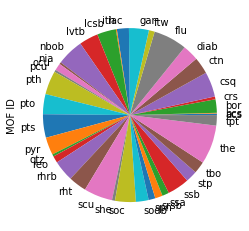

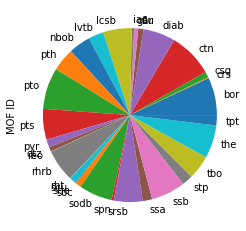

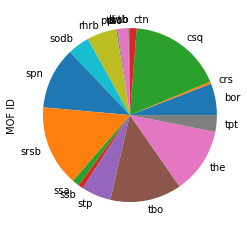

In [7]:
for i in range(6):
    Cluster1=abridge[abridge["Cluster"]==i]
    Cluster1.groupby("topology").count()["MOF ID"].plot.pie(y=f"Cluser {i}")
    plt.show()

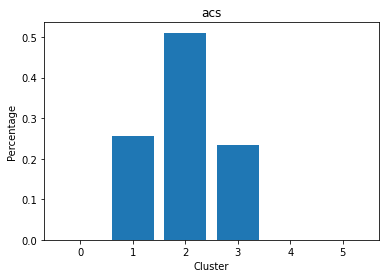

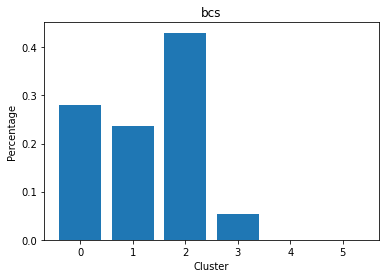

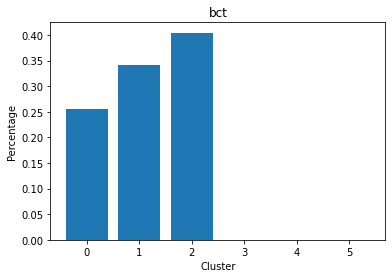

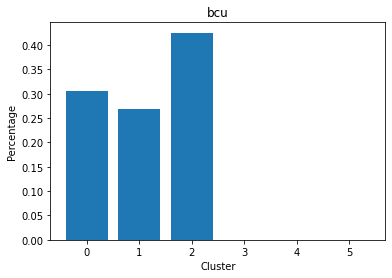

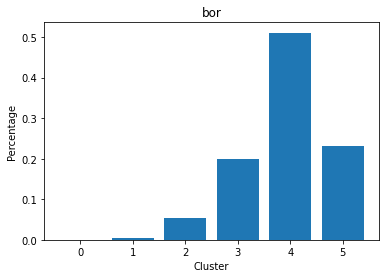

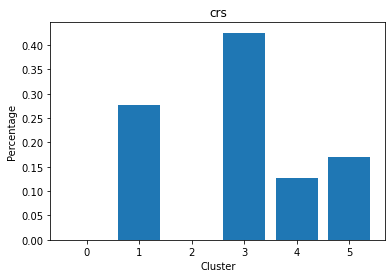

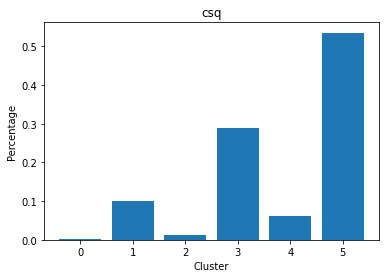

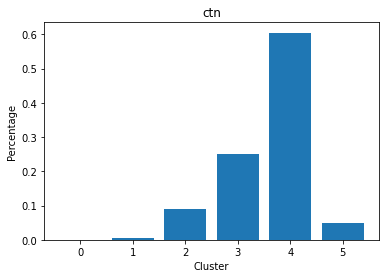

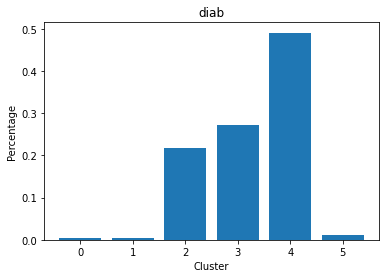

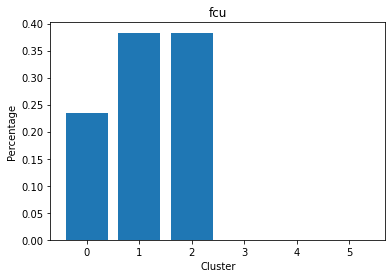

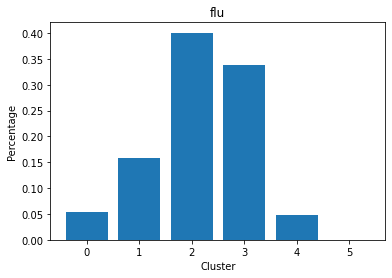

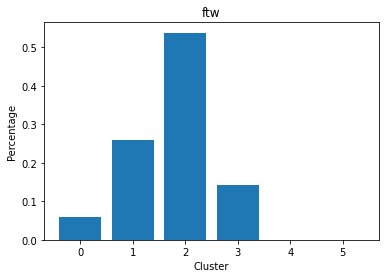

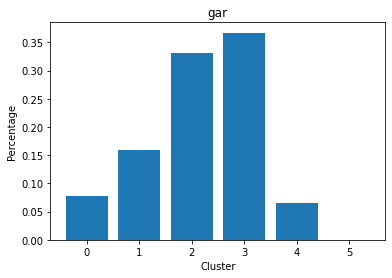

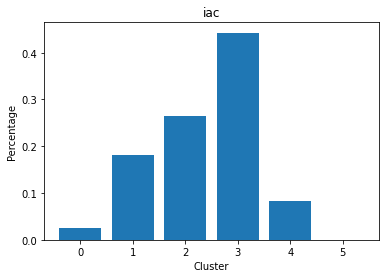

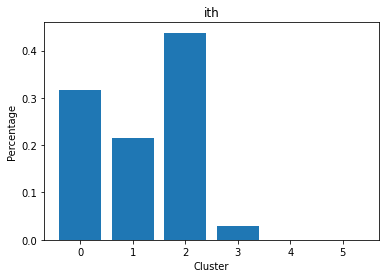

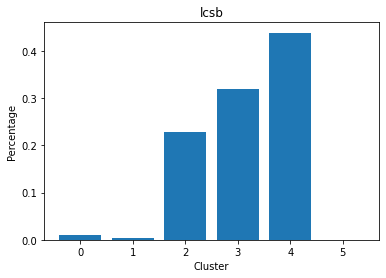

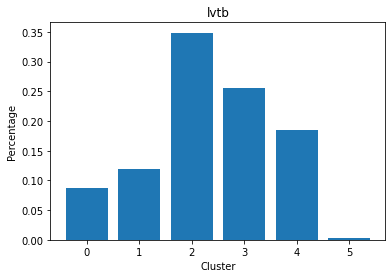

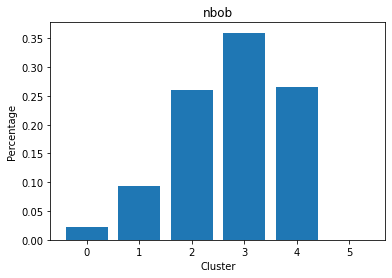

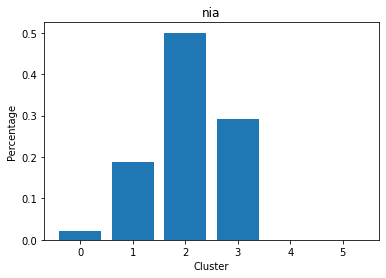

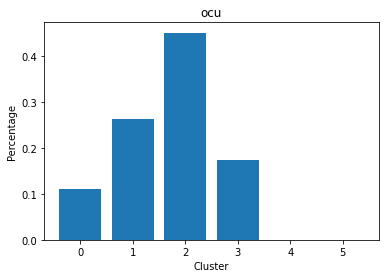

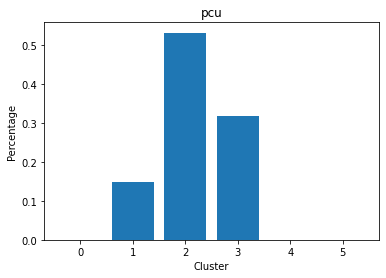

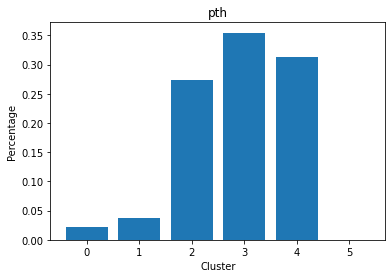

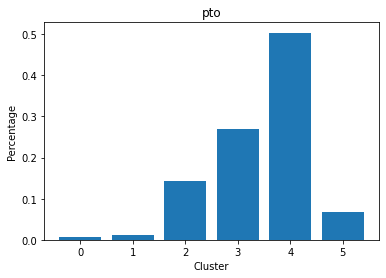

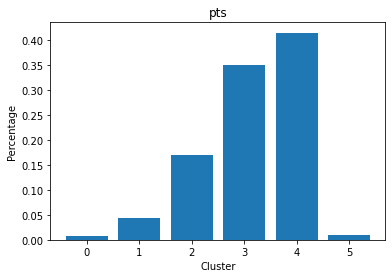

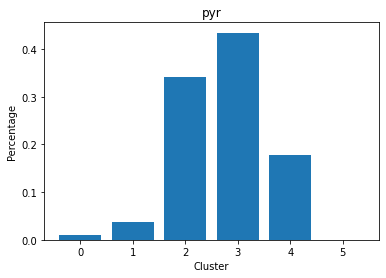

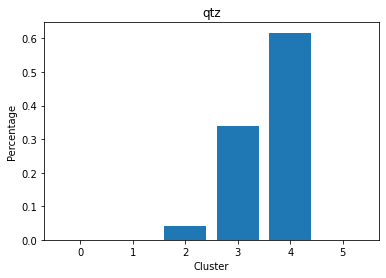

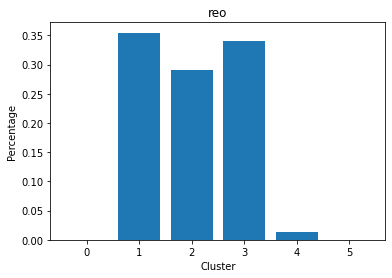

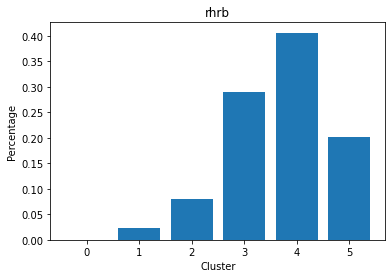

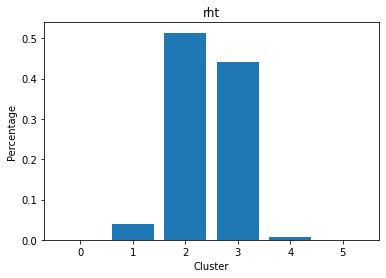

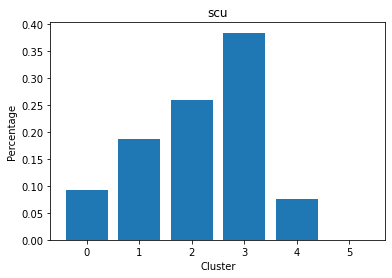

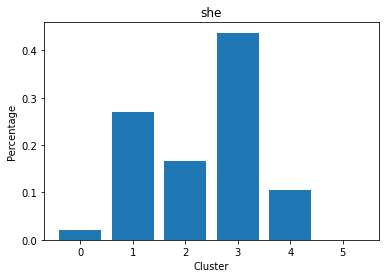

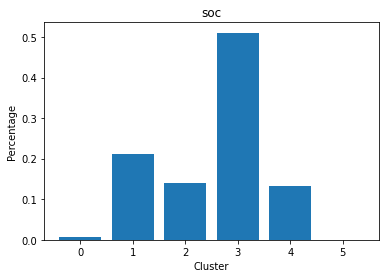

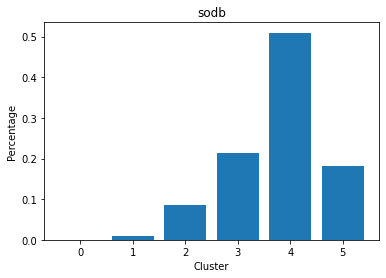

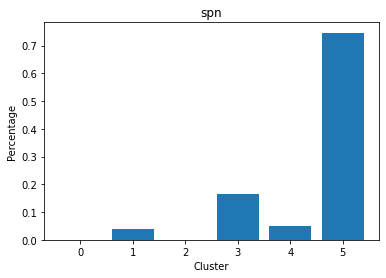

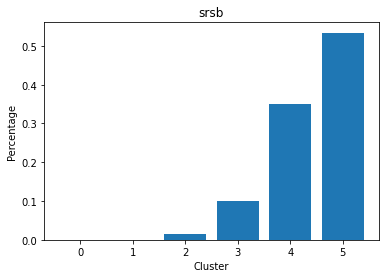

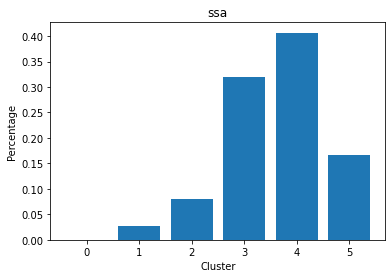

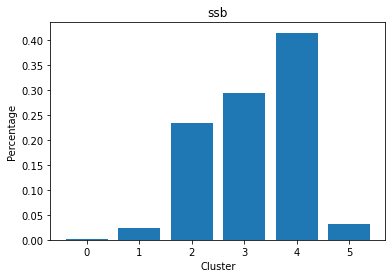

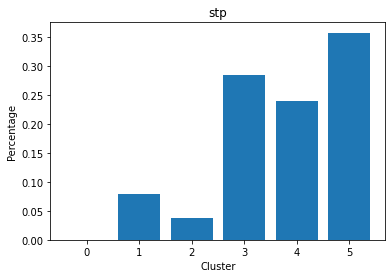

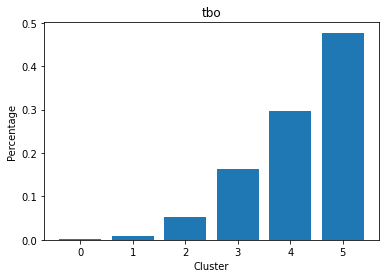

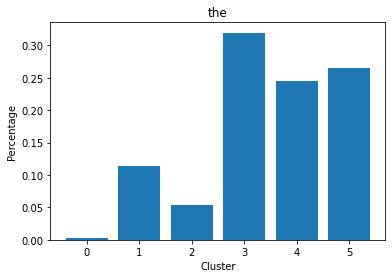

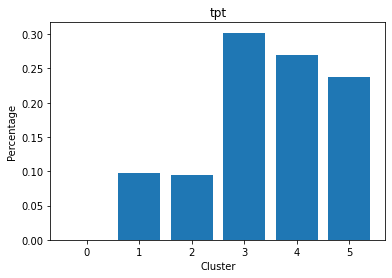

In [8]:
for i in dic:
    dic[i]=np.array(dic[i])
    dic[i]=dic[i]/sum(dic[i])
    plt.bar([0,1,2,3,4,5],dic[i])
    plt.title(i)
    plt.ylabel("Percentage")
    plt.xlabel("Cluster")
    plt.show()

/Users/gregcooper/opt/anaconda3/envs/Transfer/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


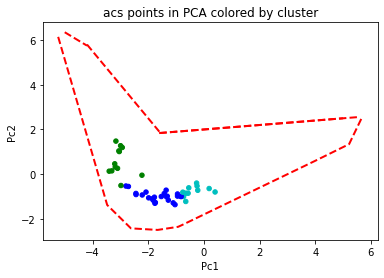

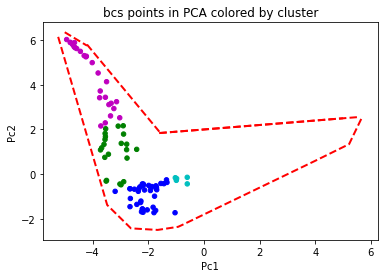

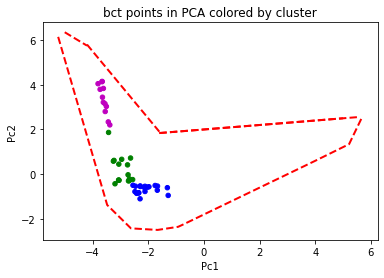

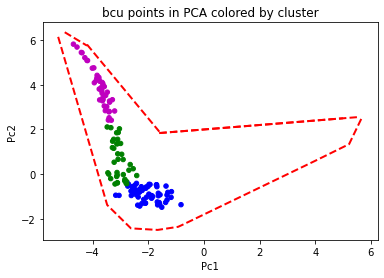

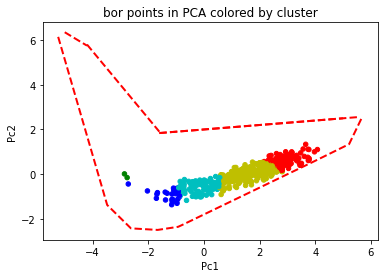

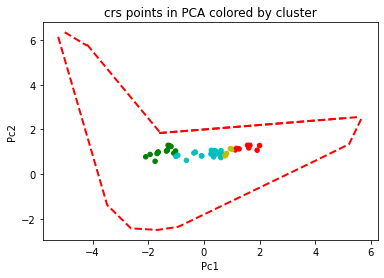

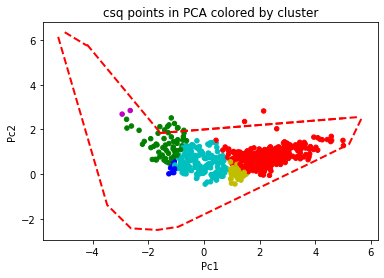

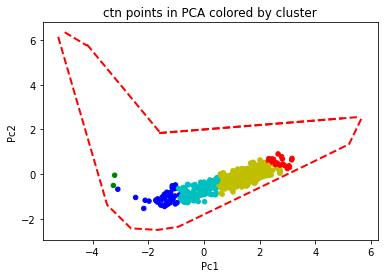

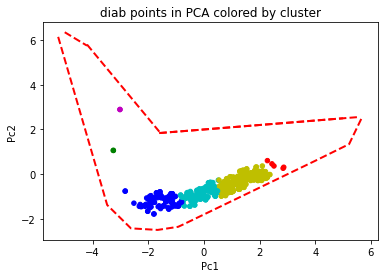

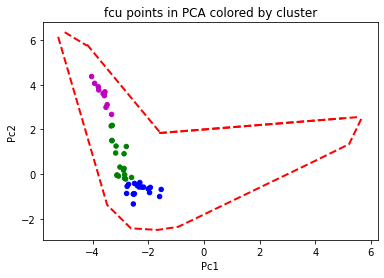

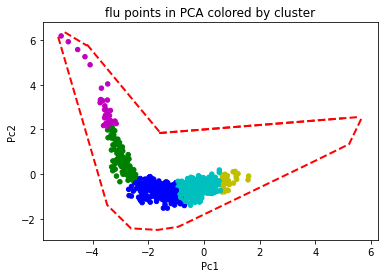

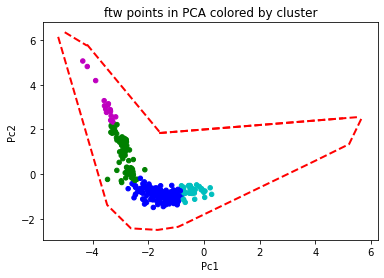

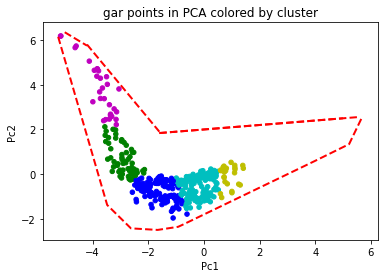

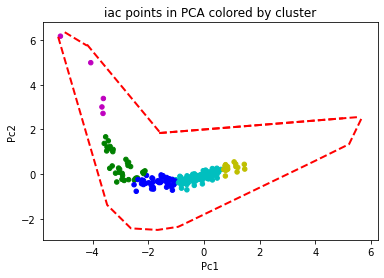

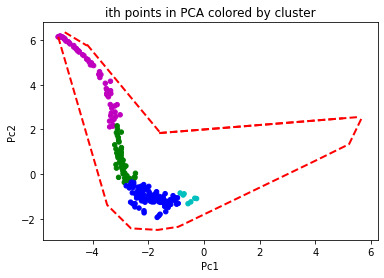

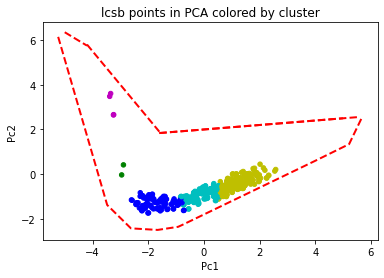

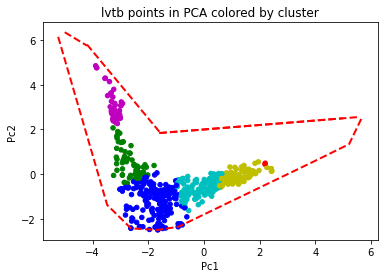

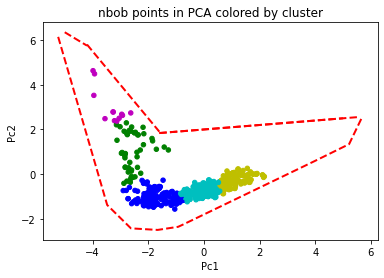

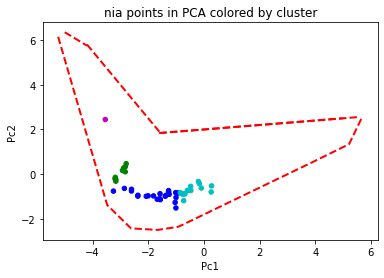

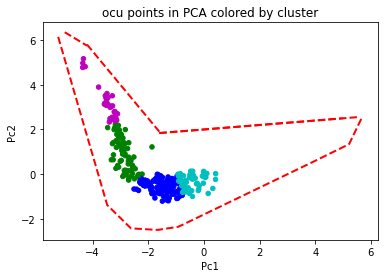

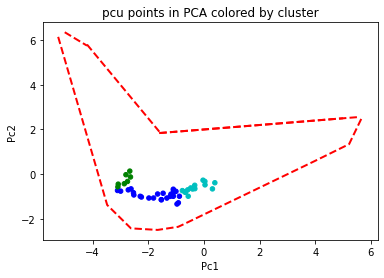

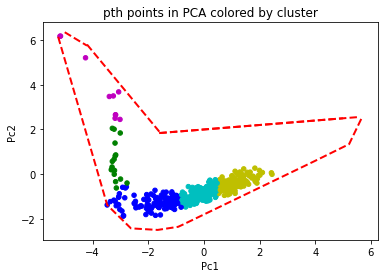

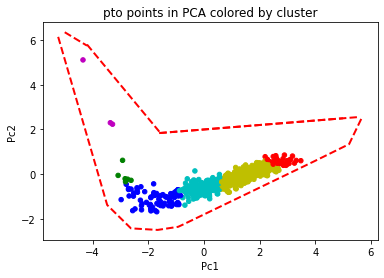

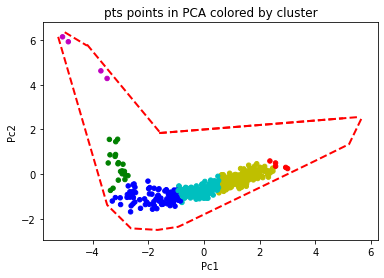

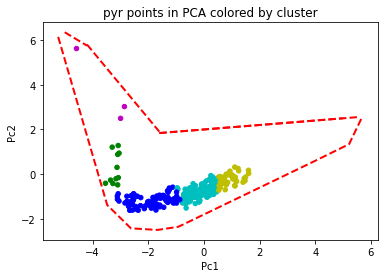

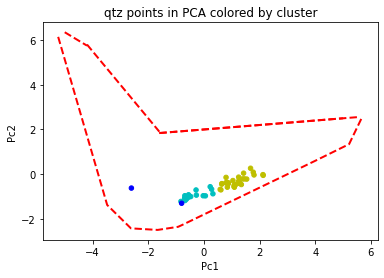

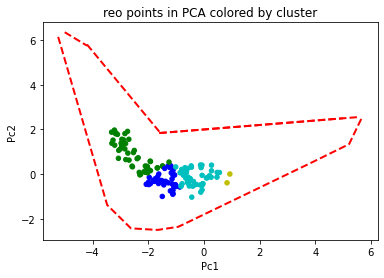

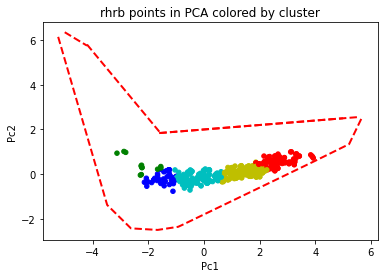

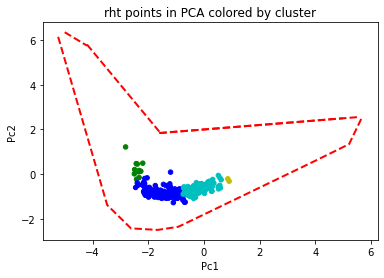

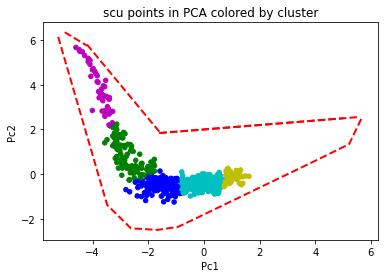

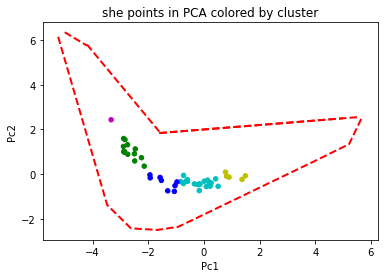

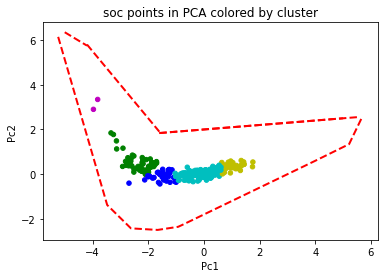

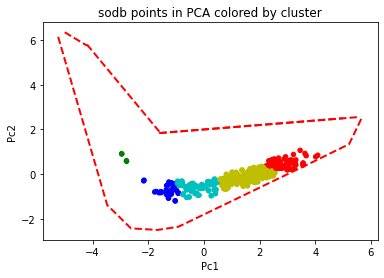

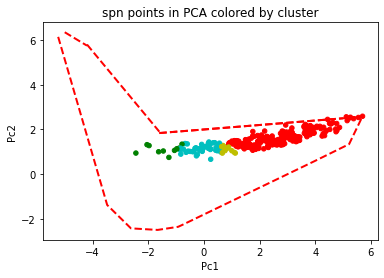

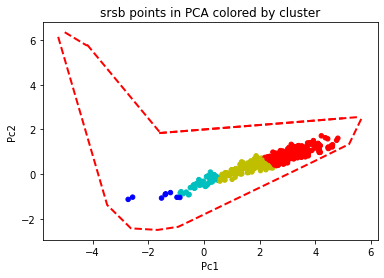

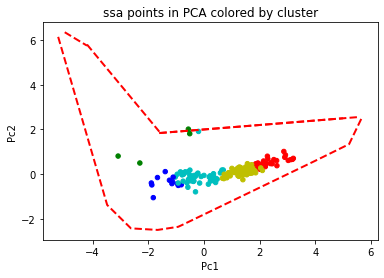

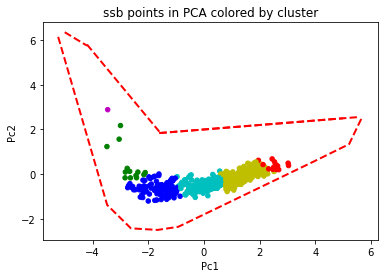

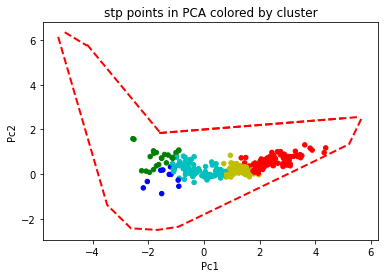

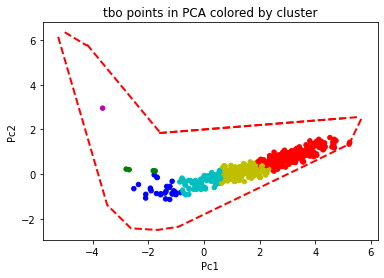

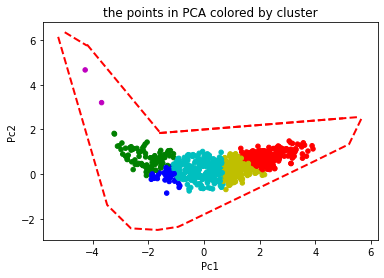

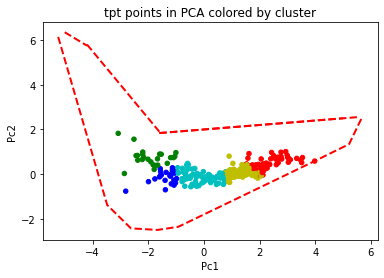

In [13]:
def color_swap(x):
    #swaps clusters to order from left to right on pca
    x=int(x)
    y=0
    if x == 5:
         y="r"
    elif x == 2:
        y= "b"
    elif x== 1:
        y="g"
    elif x == 4:
        y= "y"
    elif x == 0:
        y= "m"
    else:
        y="c"
    return y
for i in (abridge["topology"].unique()):
    interest=i
    abridge[abridge["topology"]==interest][["Pc1","Pc2","Cluster"]].plot.scatter(x="Pc1",y="Pc2",c=abridge[abridge["topology"]==interest]["Cluster"].apply(color_swap))
    plt.title(f"{i} points in PCA colored by cluster")
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)

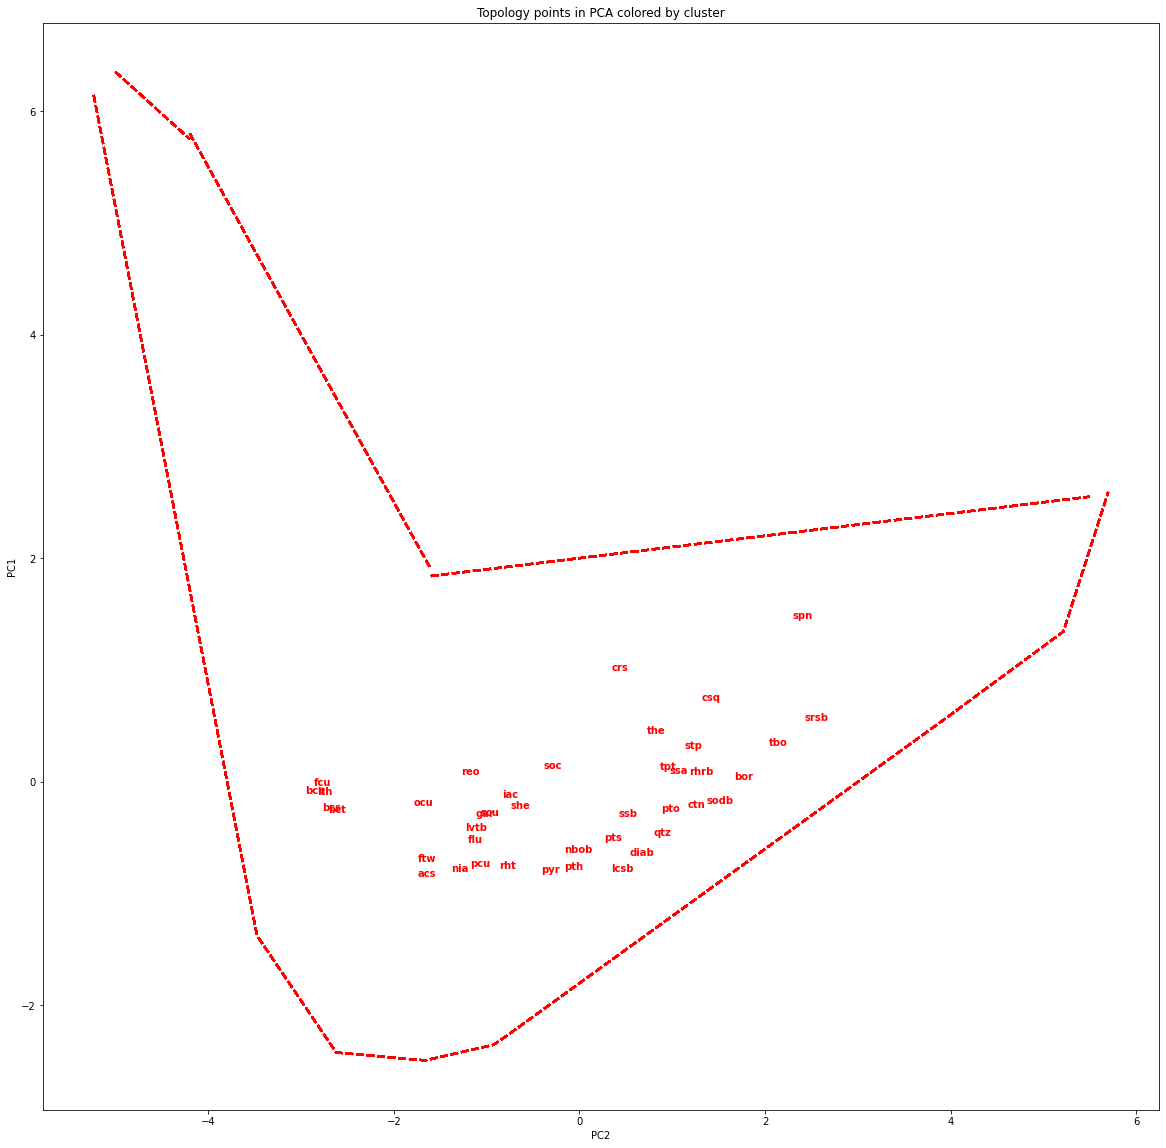

In [12]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
for z,i in enumerate(abridge["topology"].unique()):
    interest=i
    abridge[abridge["topology"]==interest][["Pc1","Pc2"]].median()
    a,b=abridge[abridge["topology"]==interest][["Pc1","Pc2"]].median().to_numpy()
    plt.annotate(interest, (a,b),weight='bold',c="r",size=10)
    plt.title(f"{i} points in PCA colored by cluster")
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
plt.title("Topology points in PCA colored by cluster")
plt.ylabel("PC1")
plt.xlabel("PC2")
plt.show()

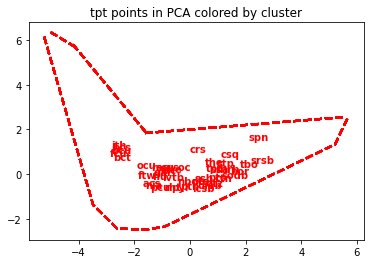

In [13]:

for z,i in enumerate(abridge["topology"].unique()):
    interest=i
    abridge[abridge["topology"]==interest][["Pc1","Pc2"]].mean()
    a,b=abridge[abridge["topology"]==interest][["Pc1","Pc2"]].mean().to_numpy()
    plt.annotate(interest, (a,b),weight='bold',c="r",size=10)
    plt.title(f"{i} points in PCA colored by cluster")
    x=np.linspace(-4.2,-1.6,1001)
    y= lambda x: -.5 - 1.5*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-5,-4.2,1001)
    y= lambda x: 2.6- .75*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5.5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    x=np.linspace(-1.6,5,1001)
    y= lambda x: 2 + .1*x
    plt.plot(x,y(x),'r--', lw=2)
    plt.plot(alpha_tuples[hull.vertices,0][:10], alpha_tuples[hull.vertices,1][:10], 'r--', lw=2)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


topology,acs,bcs,bct,bcu,bor,crs,csq,ctn,diab,fcu,...,soc,sodb,spn,srsb,ssa,ssb,stp,tbo,the,tpt
topology,,,,,,,,,,,,,,,,,,,,,
acs,0.000000,1.188901,1.124820,1.420978,3.522223,2.788346,3.445991,2.973867,2.294097,1.385921,...,1.665430,3.178161,4.660521,4.395257,2.874346,2.234553,3.099478,3.970844,2.788357,2.782507
bcs,1.188901,0.000000,0.065887,0.235041,4.449873,3.359681,4.207966,3.936975,3.340473,0.236326,...,2.414042,4.139070,5.357462,5.257013,3.764009,3.197880,3.945703,4.855682,3.570181,3.659685
bct,1.124820,0.065887,0.000000,0.296796,4.388248,3.308634,4.151349,3.874148,3.275601,0.283491,...,2.354911,4.076398,5.304097,5.197776,3.703030,3.134595,3.886141,4.795522,3.512228,3.598971
bcu,1.420978,0.235041,0.296796,0.000000,4.622905,3.476592,4.351660,4.118720,3.539897,0.108369,...,2.574761,4.319547,5.483113,5.414594,3.933441,3.383713,4.106272,5.019085,3.721989,3.827561
bor,3.522223,4.449873,4.388248,4.622905,0.000000,1.642765,0.789280,0.563113,1.318415,4.535422,...,2.057887,0.372373,1.573826,0.920107,0.694104,1.287807,0.603450,0.487795,1.025623,0.803710
crs,2.788346,3.359681,3.308634,3.476592,1.642765,0.000000,1.008808,1.472721,1.671400,3.374245,...,1.145456,1.568187,2.011395,2.124283,1.114573,1.309691,1.050450,1.828255,0.679404,1.032852
csq,3.445991,4.207966,4.151349,4.351660,0.789280,1.008808,0.000000,0.970199,1.594833,4.254774,...,1.812910,0.925630,1.226742,1.118436,0.736472,1.372042,0.466377,0.832036,0.657707,0.768851
ctn,2.973867,3.936975,3.874148,4.118720,0.563113,1.472721,0.970199,0.000000,0.758954,4.035158,...,1.589035,0.204502,2.038272,1.479305,0.358507,0.744159,0.530574,1.044624,0.793411,0.445589
diab,2.294097,3.340473,3.275601,3.539897,1.318415,1.671400,1.594833,0.758954,0.000000,3.466104,...,1.213230,0.947496,2.760077,2.237432,0.858800,0.371654,1.131769,1.803060,1.115488,0.835912


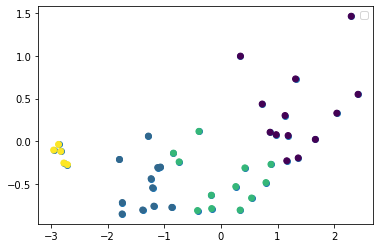

In [19]:
from scipy.spatial import distance_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
a=abridge.groupby("topology").median()[["Pc1","Pc2"]]
plt.scatter(a["Pc1"],a["Pc2"])
color = AgglomerativeClustering(n_clusters=4).fit_predict(a)
#color=gm.predict(a)
plt.scatter(a["Pc1"],a["Pc2"],c=color)
plt.legend()
distances=pd.DataFrame(distance_matrix(a,a),index=a.index,columns=a.index)
distances

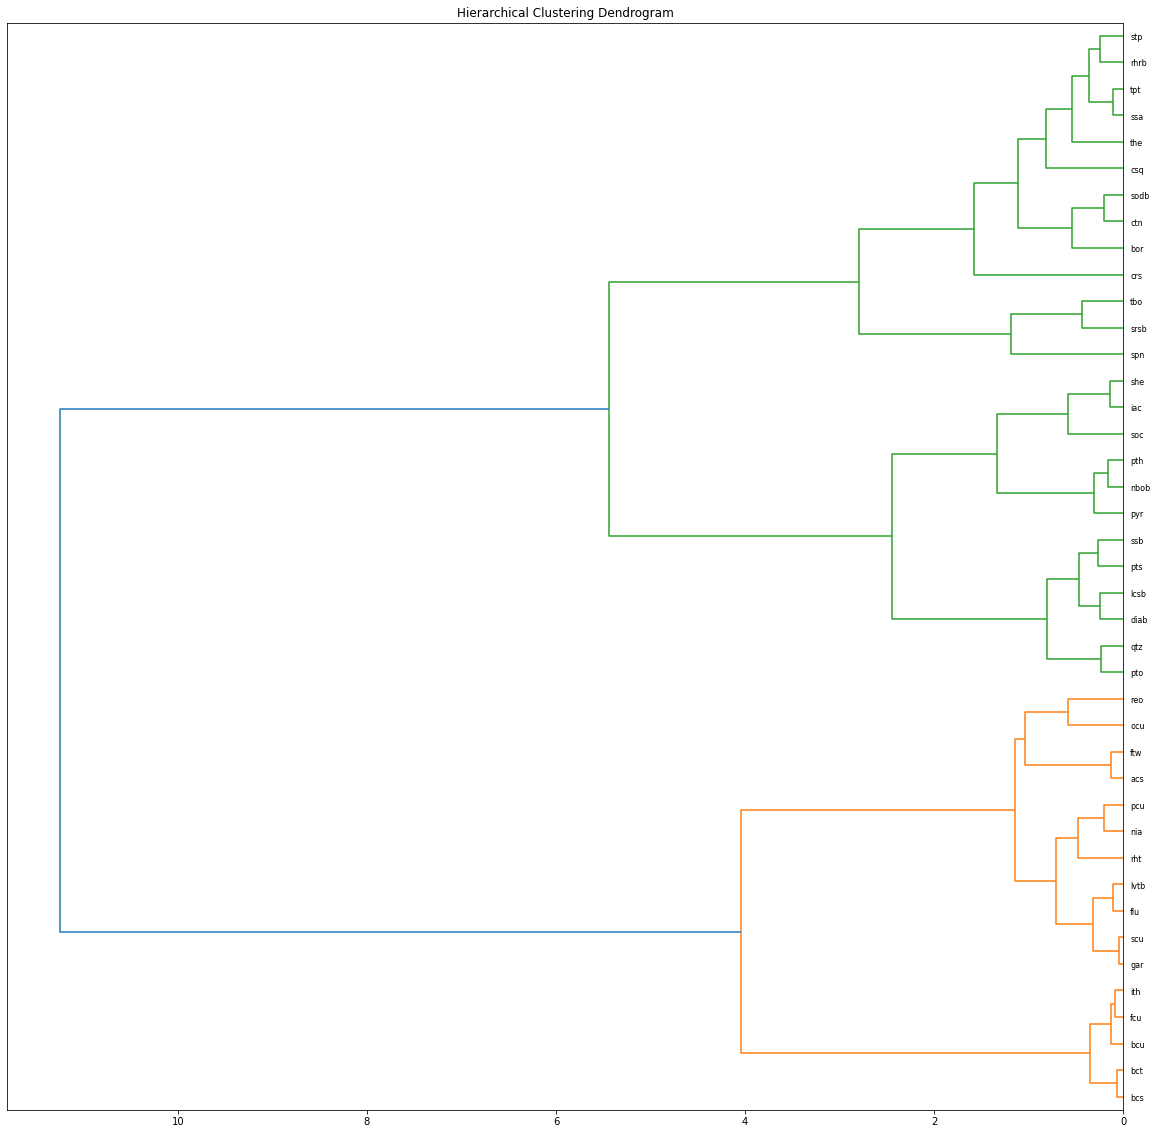

In [21]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    
    dendrogram(linkage_matrix, labels=a.index,orientation='left',)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(a)
    
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=1)